# Introduction

As a part of a recent job application, I was provided with a capability assessment project that contained *_Task_Description.rtf*, which itself contained 5 deliverables:
1. A simple description of my translation of a provided load profile into a simplified discharge profile for a cycle life test, with explanations on what simplifications I chose and the associated reasoning and potential risks (if any)
2. A flow chart of the cycle life test including charge and discharge steps, rest steps, loops and a representation of the repeating characterization cycles
3. A battery cycler script containing the cycle life test
4. A short description of future improvements
5. An estimate of how time was spent

I chose to translate the load profile with Python, so I created this Jupyter Notebook as a tool to demonstrate my Python process alongside descriptive written text and images. First, I recap the full Task Description to set the context, and then I walk stepwise through my translation procedure to produce a simplified discharge profile. Then, I show that discharge profile in a cycling procedure flow chart, and before demonstrating that procedure in a ready-to-use cycling script. Finally, I conclude with comments on the potential future of this project and an estimation of how I spent my time with this work.

In the end, I provide a **simplification of the Load Profile that features only 6 easily programmable steps** and a **Cycling Protocol that takes 8.5 months to complete 600 representative cycles with intermittent characterizations**.

# The Problem Statement

The task itself contained many meaningful pieces of information, featured below with a few of my own thoughts.

**Goal:** translate typical load profile (in .csv) to a cycle life test protocol (Maccor)

**Load Profile:**
- repeated twice a day, everyday
    - after use, enter **standby** for 30min, then **off** until next use
- recharge fully once battery is fully depleted

**Battery Pack:**
- 1S2P --> same nominal voltage range, double nominal capacity
    - each cell is 1,800mAh --> 3,600mAh pack

**Electronics:**
- charge: CCCV to 4.20V, 90mA @ 2,500mA (~0.69C)
- discharge cutoff: 3.0V (under load)
- standby current: 150mA --> standby = 75mAh x2 in a day = 150mAh (0.042C --> ~C/20)
- off current: 0.1mA --> 20hrs off in a day --> 2mAh in a day
    - outside of load profile, 152mAh drain per day: 23.68 days to 1 cycle

**Cycle Life Test:**
- \>= 600 cycles (representing ~5yrs of life)
- test < 9mo
- 2 characterization cycles @: 0, 50, 100, 150, 200, 300, 400, 500, 600
    - C/5
    - SSR (don't need to program for this assignment - HPPC every 10%?)
- characterization cycles count toward the 600
- run at 25C

**Deliverables:**
1. simplified discharge profile based on load profile
2. flow chart of the cycle life test
3. battery cycler script w/ comments
4. description of next steps (aux temp control perhaps?)
5. estimate of how time was spent

**Evaluated On:**
1. translation of load profile to discharge protocol
2. cycle life test protocol

# Deliverable #1: Load Profile Translation and Description of Process 

It's clear that one of the major deliverables, and one of the core items that the rest of this project is wrapped around, is the correct translation of the load profile contained in the file *Load_Profile.csv*. To start, this file can be opened in a text editor to look at its contents.

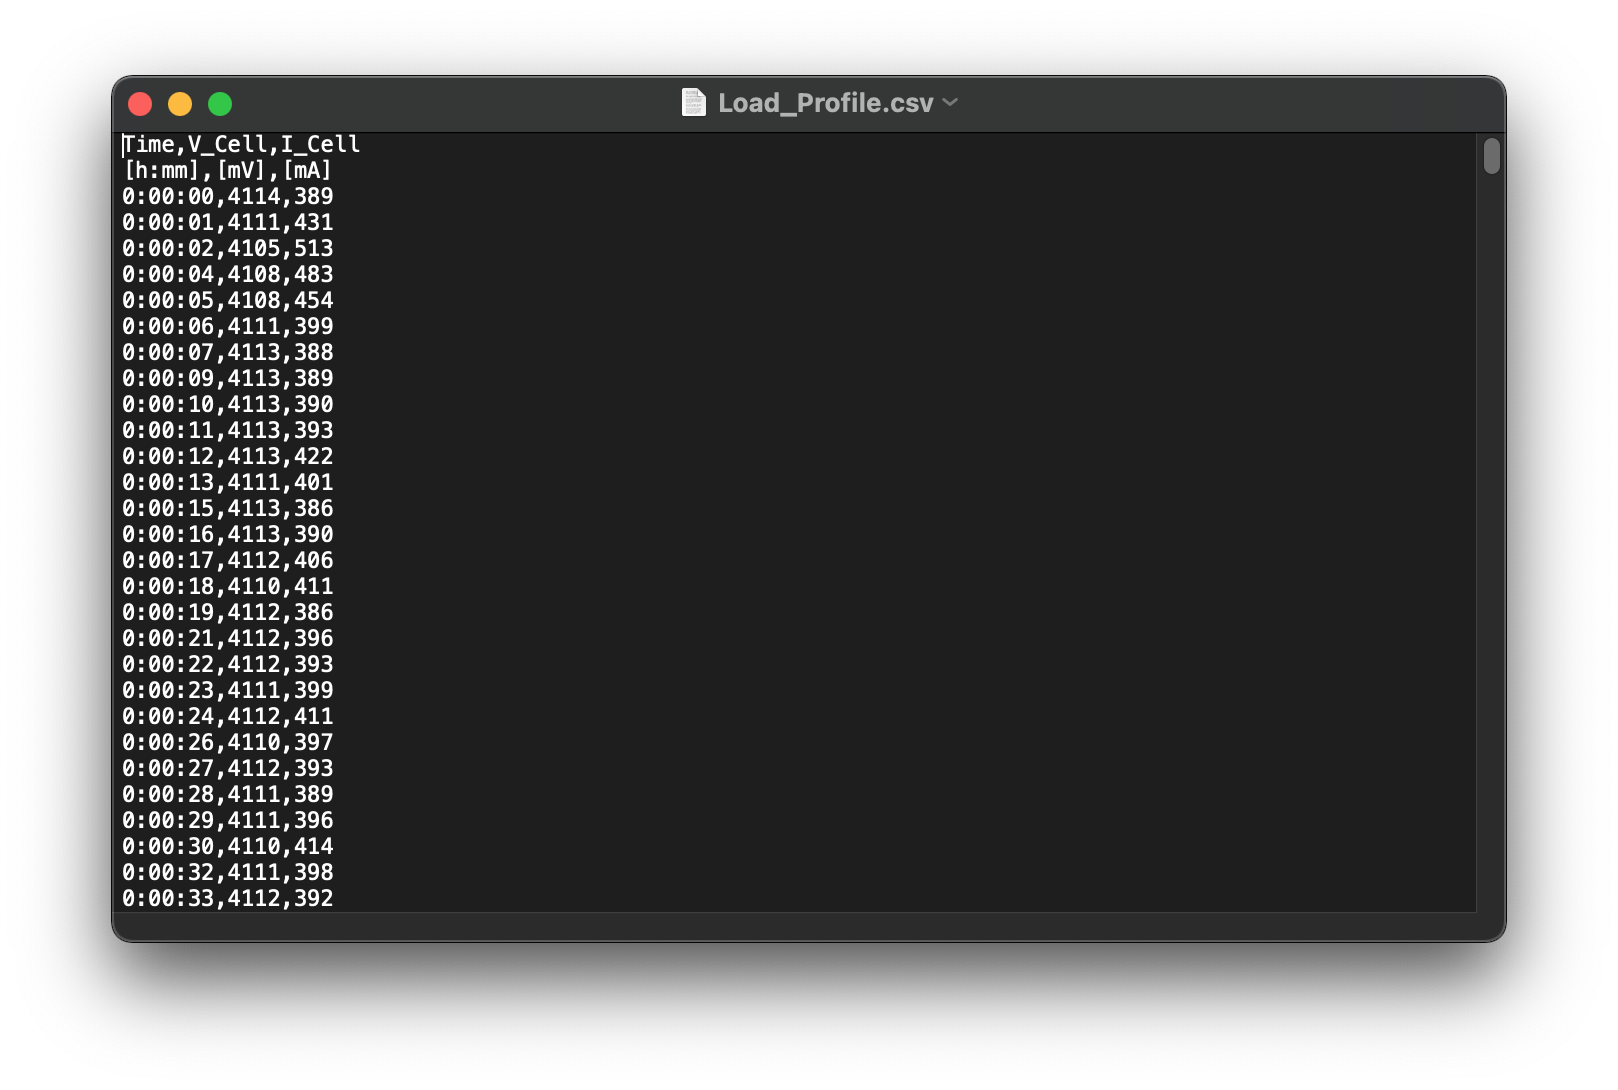

Like nearly any .csv file, the data is challenging to internalize at first glance, so a visual will help to understand what's going on. Python is a great tool for this because there are several simple tools for manipulating large datasets: numpy for array objects, pandas for tabular data, and matplotlib for data visualization - the goal at this step. Additionally, the SciPy Signal Processing .signal package and Python *time* package are included for signal processing and handling time strings, respectively; these inclusions make sense because those two work flows are present in this work. These tools might seem overkill for this dataset, as opposed to MS Excel, however these tools will be important for rapidly processing the larger datasets produced by the ultimately proposed cycle life script and it makes sense to demonstrate their capability.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import time

Next, IPython "line magic" is used to plot the matplotlib figures inline when calls are made to matplotlib.pyplot.show(), just to make this document look nice.

In [2]:
%matplotlib inline

To get the data from the .csv file into Python, the data can be read into a pandas DataFrame object. This particular data starts with two rows of textual information, and a DataFrame will automatically assign the first row of tabular data as column labels, thereby "using up" that row of information, and default to creating new indices as row labels for each row afterwards, instead of using up the first column of data, which is good for this project. However, this .csv data also has a second row of information that corresponds to the units of each column before the bulk of the data begins. This row needs to be removed for simpler access to the bulk values, but kept in mind for later context. Also, this particular file features several blank rows that need to be cleaned as well, as seen in the image below.


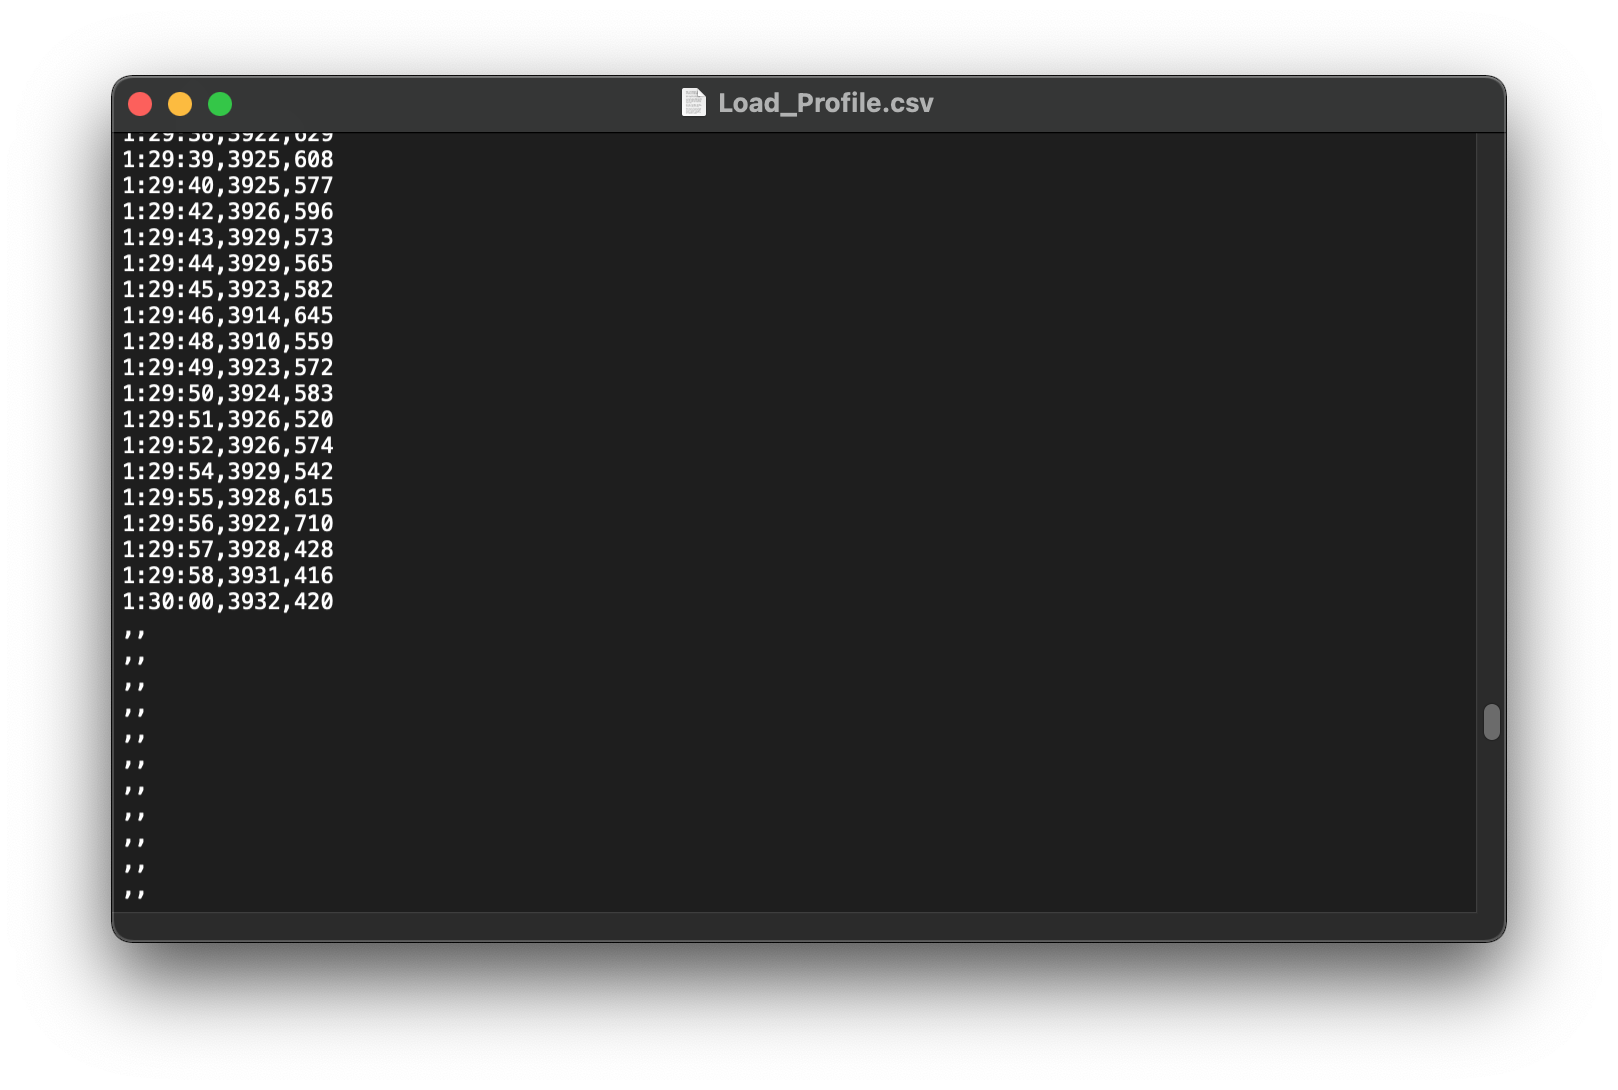

Lastly, the data in the Time column in its current form isn't easy to work with, so a function to represent the time data as seconds can be written and applied to the column for easier handling. Finally, for our visualization, a current vs. time chart can be created using matplotlib and can be seen after the code below.

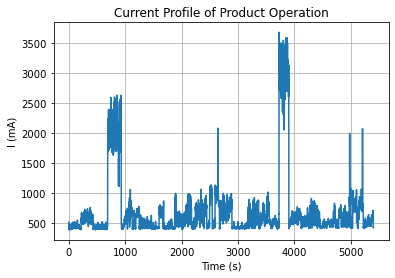

In [3]:
#read in datasheet as pandas DataFrame object
load_prof = pd.read_csv('Load_Profile.csv')

#Clean up data
#1: remove units row 0
load_prof.drop(index=0, inplace=True)
#2: remove empty rows
load_prof.dropna(how='all', inplace=True)

#we want to handle time as seconds: we'll need a function to interpret, then apply to the DataFrame
def time_second(t):
    s = time.strptime(t, '%H:%M:%S')
    return s[5]+(s[4]*60)+(s[3]*3600)
load_prof['Time-s'] = load_prof['Time'].apply(time_second)
time_s = load_prof.loc[:, 'Time-s'].tolist()

#extract current column from load_prof DataFrame as a list
current = load_prof.loc[:,'I_Cell'].tolist()
#map strs to ints in current list
current = list(map(int, current))

#plot current vs time to get an idea of the shape
plt.plot(time_s, current)
plt.xlabel('Time (s)')
plt.ylabel('I (mA)')
plt.title('Current Profile of Product Operation')
plt.grid(True)

This profile is fairly erratic, so it benefits from being cleaned up. The SciPy Signal package can be used to apply a Savitzky-Golay filter to smooth out the data, but while preserving the tendency. A deeper application of a low-pass filter would likely be even more beneficial.

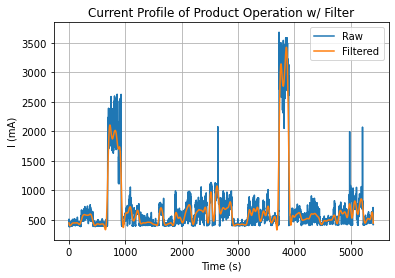

In [4]:
#create a for-loop with var current_filter so multiple passes can be played with easily
current_filt = current
for i in range(200):
    current_filt = signal.savgol_filter(current_filt, 21 , 3)

#plot the filtered data over the raw data    
plt.clf()
plt.plot(time_s, current)
plt.plot(time_s, current_filt)
plt.xlabel('Time (s)')
plt.ylabel('I (mA)')
plt.title('Current Profile of Product Operation w/ Filter')
plt.legend(['Raw', 'Filtered'])
plt.grid(True)

This is still fairly noisy, but 3 distinct current-level regions that can be used for testing begin to show themselves:
1. Current-level is between roughly 2,500mA and 3,600mA
2. Current-level is between roughly 1,100mA and 2,500mA
3. Current-level is less than roughly 1,100mA

The approach then is to select the data points from each region into a group, calculate the RMS current value on each group, and sum the time spent in that group. Using the RMS current value will more clearly give a representative current for each group, and the time will define the length of the final discharge profile each group will occupy.

In [5]:
#cast current and time back to a numpy array
current = np.array(current)
time_s = np.array(time_s)

#create subsets of current based on the above stated logic and calculate RMS value
region_1 = current[current > 2500]
region_2 = current[np.logical_and(current > 1100, current <= 2500)]
region_3 = current[current <= 1100]
r1_rms = (np.sum(region_1**2)/len(region_1))**0.5
r2_rms = (np.sum(region_2**2)/len(region_2))**0.5
r3_rms = (np.sum(region_3**2)/len(region_3))**0.5

#each data point is almost a second long, but not quite
#figure out average of interval to make region dwell time calculation easier
interval = time_s[-1]/len(time_s)

r1_time = len(region_1)*interval
r2_time = len(region_2)*interval
r3_time = len(region_3)*interval

print('Region 1 average current is ' + str(round(r1_rms)) + 'mA and ' + str(round(r1_time)) + 's long.')
print('Region 2 average current is ' + str(round(r2_rms)) + 'mA and ' + str(round(r2_time)) + 's long.')
print('Region 3 average current is ' + str(round(r3_rms)) + 'mA and ' + str(round(r3_time)) + 's long.')

Region 1 average current is 3065mA and 174s long.
Region 2 average current is 1864mA and 260s long.
Region 3 average current is 571mA and 4966s long.


Then, these three regions need to be checked together in one discharge profile to confirm they make sense before moving on.

In [6]:
#add up length of time of each region to compare to 5400s of the original profile
model_time = r1_time+r2_time+r3_time

#calculate the capacity used per profile: raw, then model
time_h = time_s/3600
raw_cap = np.trapz(current, time_h)
model_cap = (r1_rms*(r1_time/3600))+(r2_rms*(r2_time/3600))+(r3_rms*(r3_time/3600))

print('The model takes '+str(round(model_time))+"s compared to the load profile's 5400s.")
print('The model uses '+str(round(model_cap))+"mAh compared to the load profile's "+str(round(raw_cap)) + 'mAh.')

The model takes 5400s compared to the load profile's 5400s.
The model uses 1071mAh compared to the load profile's 1040mAh.


All in all, this now seems to be a reasonable breakdown of the original load profile. It's true that Region 3 especially, the low current region, is smoothing out a lot of the real-life noise/variability, and that in reality a rapidly changing profile may add more stress to a cell than a constant profile. However, based upon the caculations above, the model is shown to pull a slightly higher overall current than the real-life cell (+30mAh per discharge), so it can be considered that this somewhat more aggressive condition may possibly make up for the loss of stress from the raw profile noise. 

With the group of 3 regions looking representative, the regions further need to be fit into the 5400s run time in a way that mimics reality. Region 1 looks continuous until 4000s, and Region 2 looks continuous until 1000s. Region 3 appears to be split into three sections around the other two.

In [7]:
print('Region 3a (' + str(round(r3_rms)) + 'mA) : from 0s to ' + str(round(1000-r2_time)) + 's.')
print('Region 2  (' + str(round(r2_rms)) + 'mA): from ' + str(round(1000-r2_time)) + 's to 1000s.')
print('Region 3b (' + str(round(r3_rms)) + 'mA) : from 1000s to ' + str(round(4000-r1_time)) + 's.')
print('Region 1  (' + str(round(r1_rms)) + 'mA): from ' + str(round(4000-r1_time)) + 's to 4000s.')
print('Region 3c (' + str(round(r3_rms)) + 'mA) : from 4000s to 5400s.')

Region 3a (571mA) : from 0s to 740s.
Region 2  (1864mA): from 740s to 1000s.
Region 3b (571mA) : from 1000s to 3826s.
Region 1  (3065mA): from 3826s to 4000s.
Region 3c (571mA) : from 4000s to 5400s.


With a definition of the regions to model, and their position in the profile, the model can be compared to the raw data.

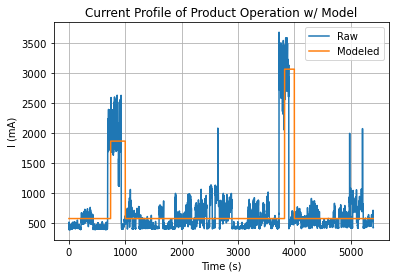

In [8]:
#create model data in a list
model_profile = []
for s in range(740):
    model_profile.append(r3_rms)
for s in range(1000-740):
    model_profile.append(r2_rms)
for s in range(3826-1000):
    model_profile.append(r3_rms)
for s in range(4000-3826):
    model_profile.append(r1_rms)
for s in range(5400-4000):
    model_profile.append(r3_rms)

#plot model data over raw data
plt.clf()
plt.plot(time_s, current)
plt.plot(model_profile)
plt.xlabel('Time (s)')
plt.ylabel('I (mA)')
plt.title('Current Profile of Product Operation w/ Model')
plt.legend(['Raw', 'Modeled'])
plt.grid(True)
plt.show()

This is pretty good! That said, this profile is only contains the active load on the battery, and therefore only a part of the full use case. As a part of the problem statement, the 90 minute (5400s) load is performed twice within 24hrs, with 30 minutes of a 150mA standby discharge current after each load, and otherwise a 0.1mA discharge current during the off state. With the quick investigation shown below, the sustained 150mA is somewhat substantial, representing ~7% of the 90min discharge load.

In [9]:
stby_curr = 150 #mA
stby_time = 0.5 #h

#divide cap from stby by cap from load model, show as %
print(round((((stby_curr*stby_time)/model_cap)*100), 2))

7.0


Therefore, the final load profile should have a 4th region after the group of the other 3: **150mA from 5400s to 7200s**.

The final portion of the load, the 0.1mA discharge current during the off state, can be ignored. Most importantly, this is because the test will take too long if this region is specifically included. However, this is also a safe bet. Not only is it generally known from standard industry practices that this is an insubstantial load, it can be shown mathematically. By the profile description, the battery will be in the off state for 20hrs a day, and at 0.1mA this reflects 2mAh of capacity total, or 0.17% of a cycle capacity. Over the course of the full 600 cycle test, this adds up to a descrepancy of only 3 cycles while saving years of cycling test time, as shown below. Therefore, **a 5th region will not be added to the model load profile to represent the off state**.

In [10]:
#find percentage of capacity the off state would represent
model_cap = model_cap + stby_curr*stby_time
off_cap_p = (2/model_cap)*100

#calculate how many discharge profiles we actually expect in 600 full cycles
dchg_b4_depletion = 3600/model_cap
total_dchg_steps = dchg_b4_depletion*600

#multiply steps by missing contribution percent, and convert to full steps
steps_lost = (total_dchg_steps*off_cap_p)/100

print('Off-state capacity counts as ' + str(round(off_cap_p, 2)) + '% of the profile capacity.')
print('Ignoring the off-state step for the cycle protocol overlooks ' + str(round(steps_lost)) + ' full cycles.')

Off-state capacity counts as 0.17% of the profile capacity.
Ignoring the off-state step for the cycle protocol overlooks 3 full cycles.


## Load Profile Summary

After analysis, the load profile on the battery can be described as a 2hr long series of 6 constant current steps:
1. Region 3a (571mA) : from 0s to 740s
2. Region 2  (1864mA): from 740s to 1000s
3. Region 3b (571mA) : from 1000s to 3826s
4. Region 1  (3065mA): from 3826s to 4000s
5. Region 3c (571mA) : from 4000s to 5400s
6. Region 4  (150mA) : from 5400s to 7200s


## Load Profile Critical Review

All in all, the proposed model is nice to handle because it's easy to visualize and easy to program into a battery cycler: there are only 6 steps. This is important because battery cycle life tests are very long time-wise, and it's crucial to get tests up and running as soon as possible and with the least amount of error from overly complicated programming showing up months down the line and trashing an experiment.

That being said, the proposed model is admittedly a drastic simplification of the provided load profile, reducing the profile to mostly a ~90min C/6 discharge - a condition that can be considered fairly gentle. Running a gentle cycle life test can possibly be considered a risk. However, in this case, the two briefly sustained peaks of ~C/2 and ~1C definitely represent substantially stressful conditions that come from the real profile. Including these peaks in the simplified profile allow the cell to be mostly tested at the expected "baseload" current, but with two additional reality-based stress levels per cycle that may generally represent deviations from baseload while dynamically using the product.

Furthermore, and still on the topic of the simplified C/6 current, it can be recognized that the provided load profile represents just one example load. In the context of all possible example loads, coding this specific one into a test protocol very specifically may in fact be ignoring other possible load profiles. The approach of translating the provided load profile into a broadly averaged (RMS) "baseload" current accounts for the possibility that other example load profiles may also be individually averaged into the same or similar baseload current, albeit with their own current spikes and so forth. With that in mind, it can be reasonably proposed that having the largely average discharge rate with two current spikes in the above simplified load profile may be more representative of a wider selection of sample use cases beyond the just solely provided load profile.

All in all, there can be confidence that this profile contains the majority of the meaningful battery stress a user may put on the system, even with the recognition that this simplification does in fact smooth over high frequency, low amplitude current spikes that may be potentially harmful to the cell. Future work should strive to include these features even more intelligently to make a more robust test profile, for example importing the original file to the Maccor FastWave step type (if this specific profile is indeed desired), or choosing a more intelligently selected low-pass filter to parse the original signal into more than 3 discreet current regions, or perhaps even current ramp zones. However, in the spirit of programming the simplified discharge profile manually, care should be taken to keep the total discharge steps to around 10 or so for ease of use.

# Deliverable #2: Battery Life Cycle Test Flow Chart

With the simplified load profile in hand, a battery cycle life test protocol can now be coded. To help understand this protocol, it's easiest to first develop a flow chart of the steps. In this flow chart, in addition to the discharge load, there will also be charges and characterization steps - first at every 50 cycles, and then at every 100 cycles after the first 200 battery cycles. In total, the flow chart should have:
1. A start step
2. An initial discharge so that each battery can begin testing on equal ground
3. A repeatable 50 cycle loop that contains a starting 2-cycle characterization step and 48 looping cycle steps
4. A repeatable 100 cycle loop that contains the same starting 2-cycle characterization step and 98 looping cycle steps
5. A repeatable cycle step that loops the discharge load profile until cell depletion at 3.0V
6. An End-Of-Life characterization
7. An end step

Lastly, it's good practice to include short rests after every charge or discharge operation. All of this content is packed into the flow chart below.

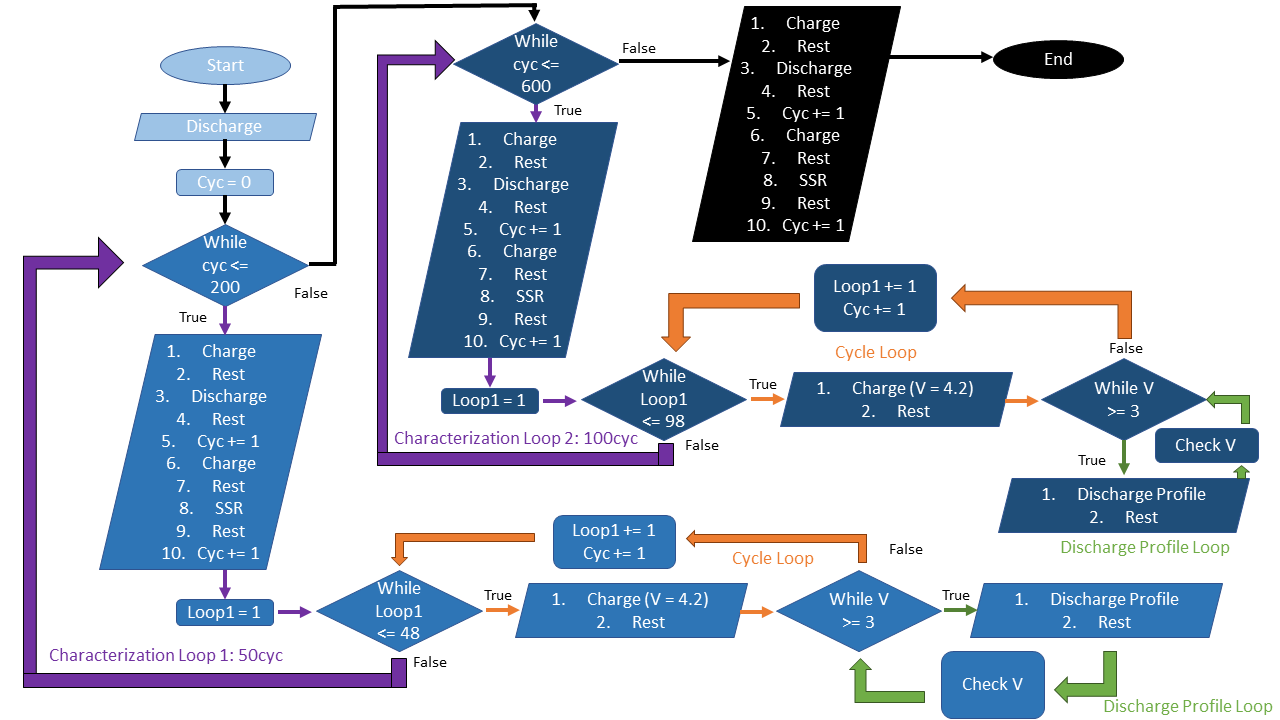

# Deliverable #3: Battery Cycle Script

To code this flow chart into a script, a Maccor cell cycler is chosen as an example, and therefore the Maccor *Build Test* application is used to write the script. However, Maccor only allows a total of 4 loops in a script, whereas the flow chart above features 6. As a result, the cycle protocol must be abstracted to a *Sub-Routine* in order to distribute the loops across multiple Maccor scripts. Furthermore, this is a generally good practice, because in the event that a modification is necessary to a repeated unit of an overall test script that uses sub-routines, the modification only needs to be made once to be applied to each use in the larger routine. This can cut down significantly on possible errors. Therefore, this mindset is also applied to the characterization step as well, even though it doesn't feature a loop that *needs* to be abstracted, since the characterization step is repeated several times throughout the full cell test.

## Characterization Script

Sub-routines must be written before the main protocol, and since the characterization step comes first in the flow chart, it makes sense to write it as a sub-routine first. (By the way, Maccor procedure files will be made available separately for closer inspection).

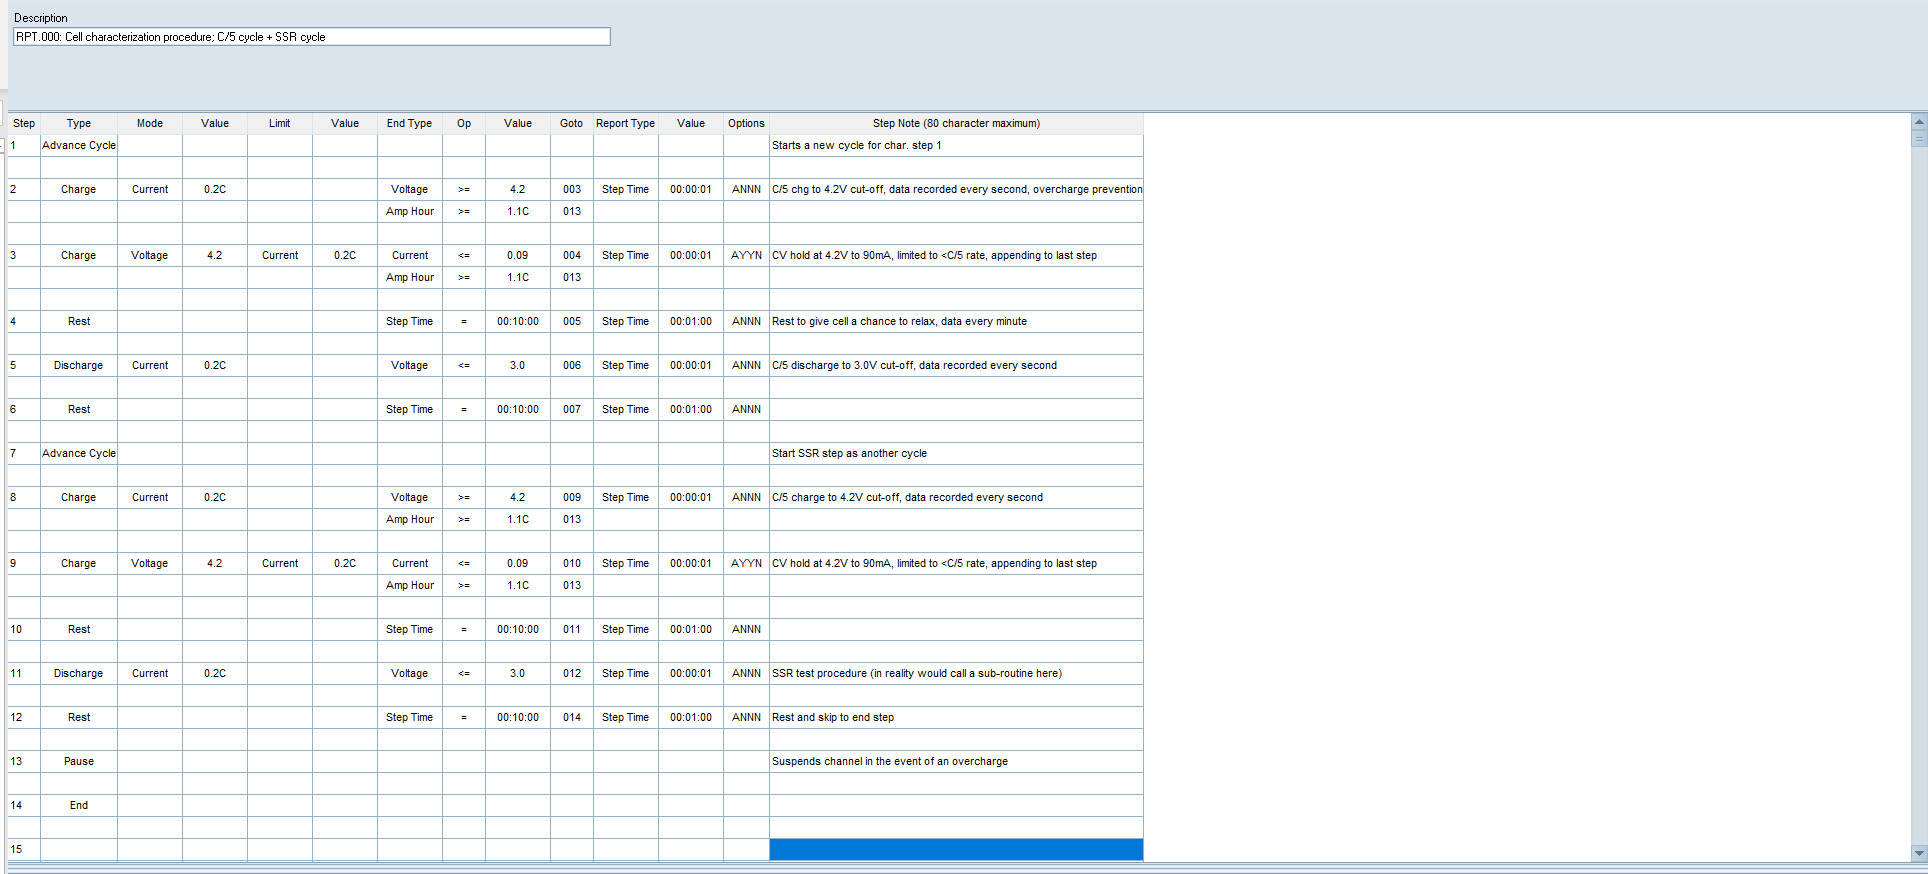

This sub-routine begins by advancing the cycle count since chracterizations cycles are stated to count towards the total. Then, it runs a CC-CV charge, a CC discharge, a second CC-CV charge, and then an SSR step that would likely be another sub-routine in reality, but is not a part of this assignment. Between each charge and discharge is a 10min rest, and during each load step a data point is recorded every 1 second to remain consistent with the resolution of the originally supplied example load profile.  This sub-routine is estimated to take **24h, 40min**:
- CC steps take 5 hours (x3)
- CV steps take 2 hours (x2)
- SSR step takes 5 hours(x1)
- Rests take 10 min (x4)

## Cycle Script

Next is the cycle sub-routine. This routine contains the product use case:
- Charge at 2500mA from a depleted state
- Discharge with the simplified load profile until depleted

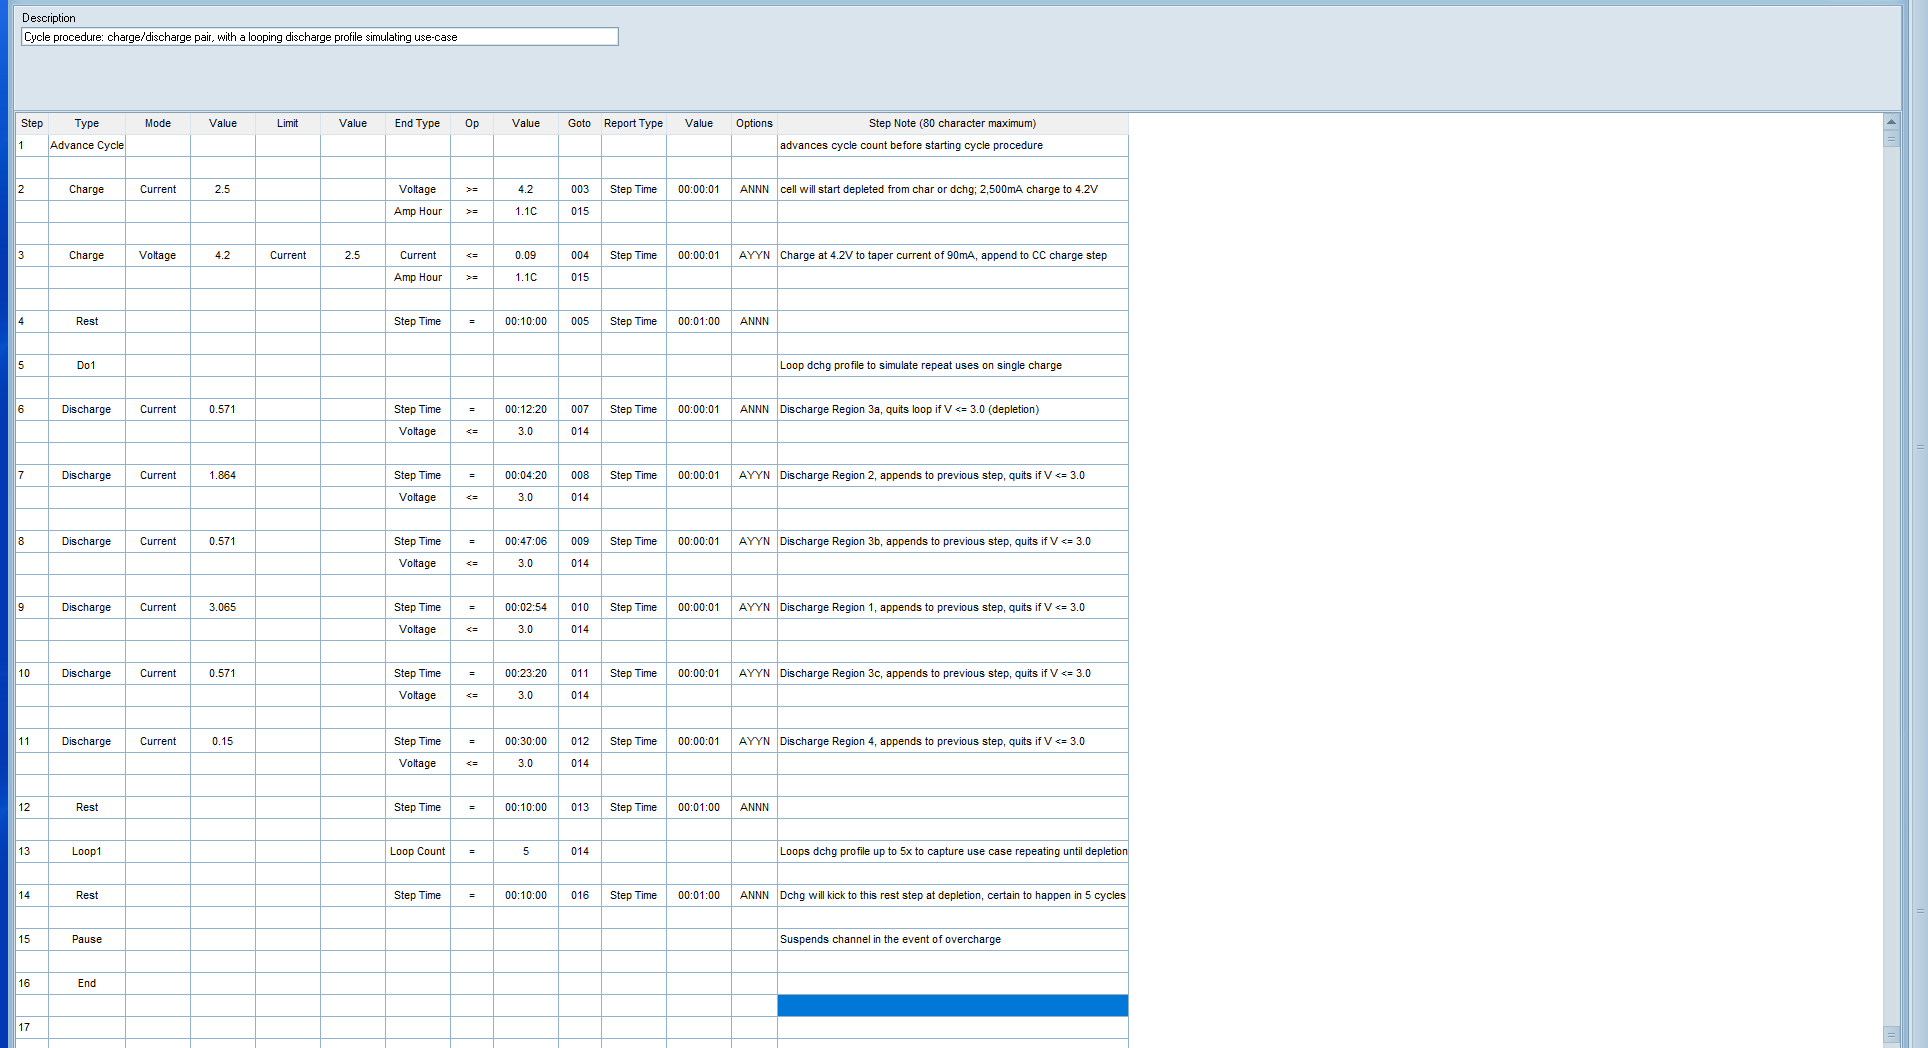

This sub-routine is estimated to take **10h, 10min**:
- CC charge takes 1.5hr
- CV charge take 1.5hr
- Discharge protocol takes 2hrs (x3.14 before the profile is expected to deplete the 3600mAh pack --> 6hrs, 20min)
- Rests take 10min (x5)

## Main Script

Last is the main routine that just calls the sub-routines in loops to achieve 600 cycles with characterization cycles at 0, 50, 100, 150, 200, 300, 400, 500, and 600 cycles.


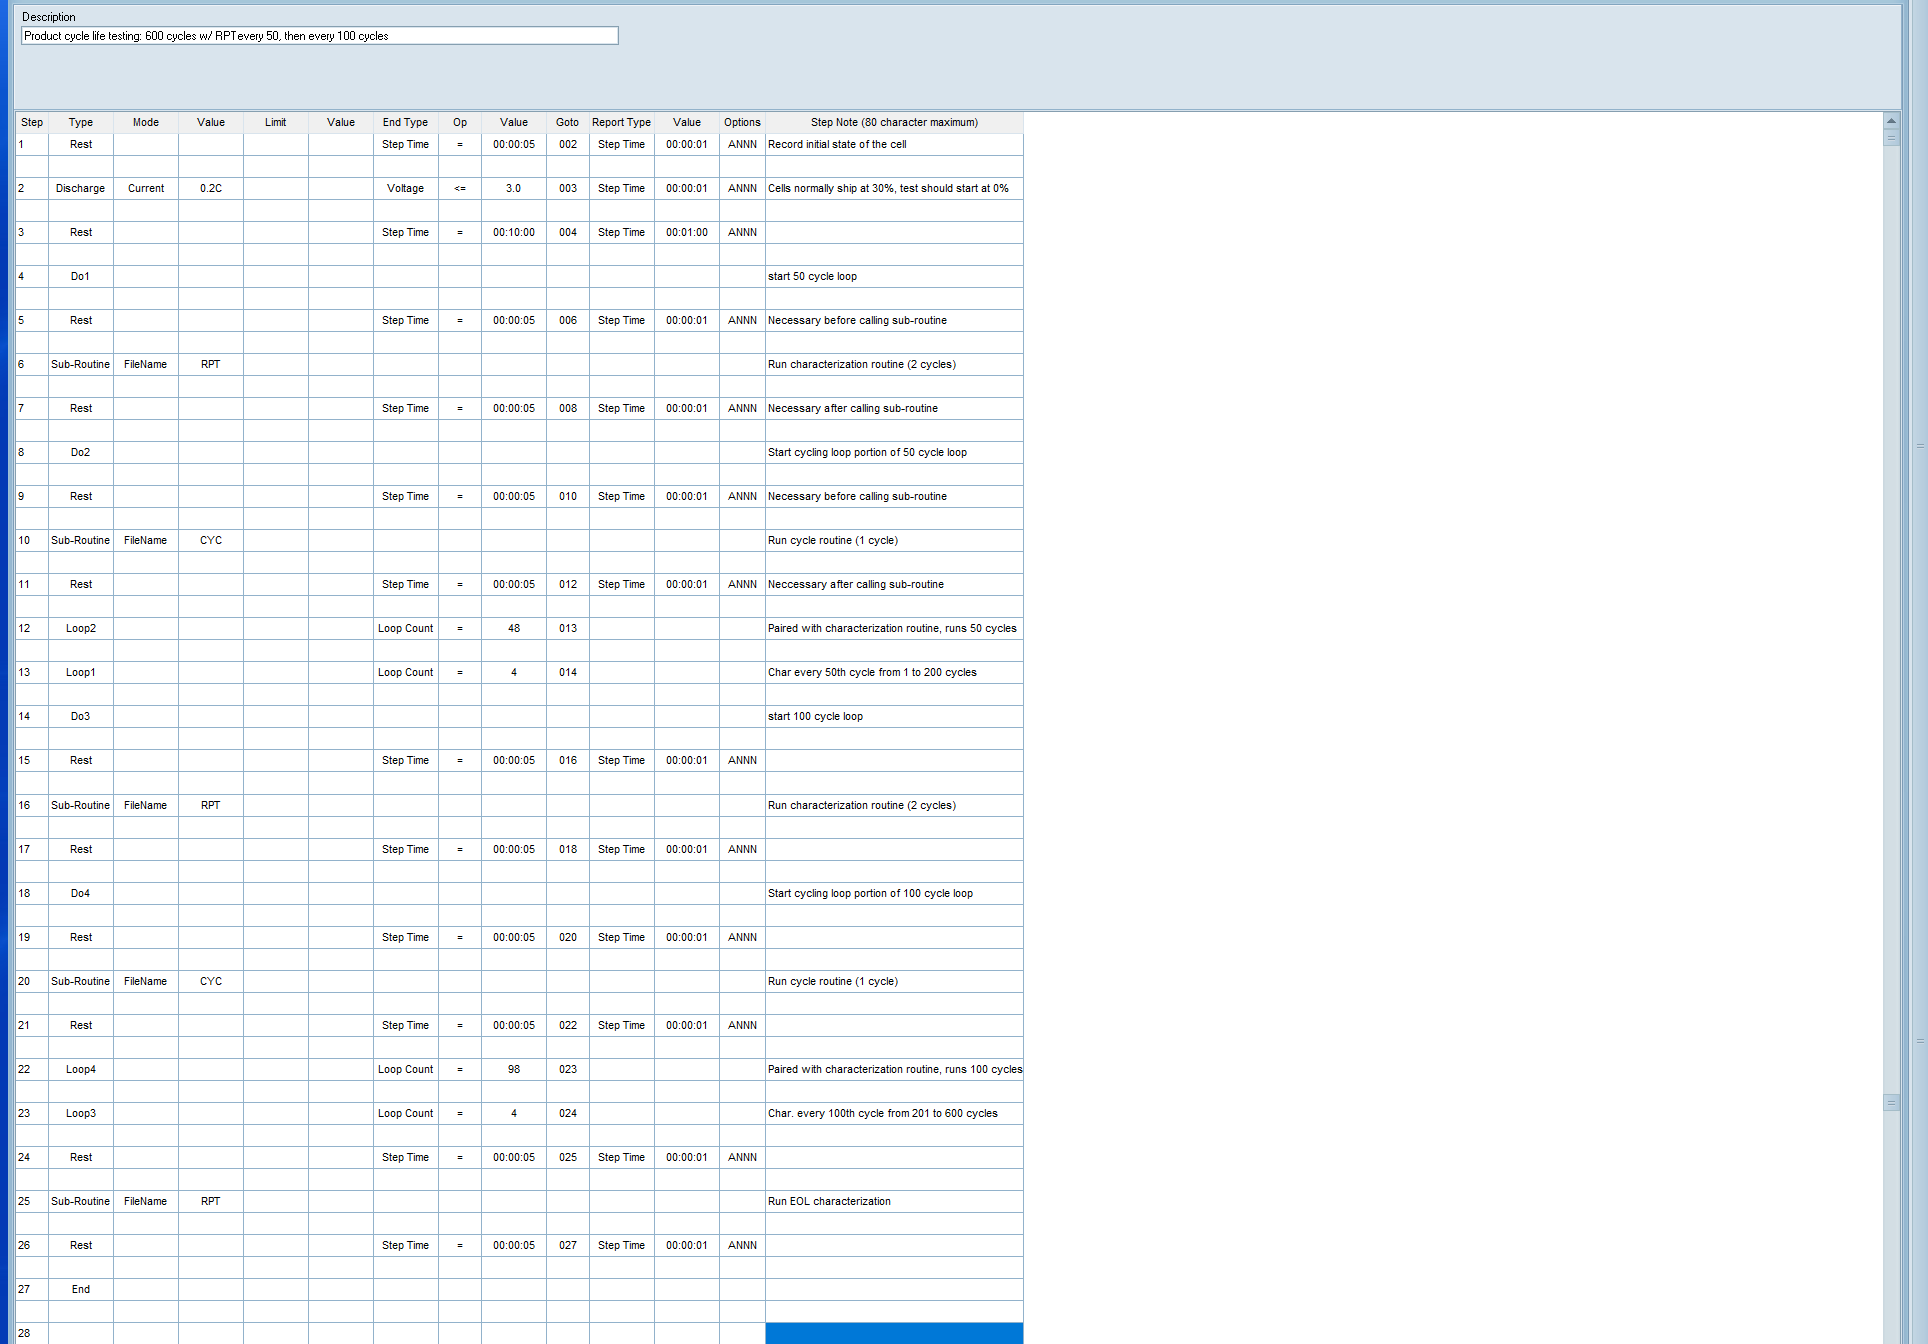

This full routine is estimated to take **8 months, 16 days, 17 hours, and 20 minutes**:
- Characterization Routine x9
- Cycle Routine x584

This meets the criteria of being less than 9 months.

## Testing Environment

The test criteria also stipulates that this test is to be run at 25C only. The above script does not take any pains to control for temperature. Instead, it is recommended that the cells be physically located in a 3rd party environmental chamber controlled to 25C, or in a room with constant HVAC control that is not periodic with normal office hours.

# Deliverable #4: Future Improvements

There are several paths to improve the suggested cycle life protocol that could be feasibly implemented within a week or two of additional work:
- The analysis featured here assumes a current-driven test, however steps could be taken to see if a voltage- or power-driven test would be easier to interpret from the raw load profile, and therefore easier to simplify into a more accurate discharge load profile
- A more robust low-pass filter to better interpret the raw load profile (in all honestly, signal processing is not a well practiced skill of mine, but now I'm very intrigued to learn the techniques better)
- Implementation of Maccor FastWave step to test the cell to this exact waveform (if this exact profile is desired for testing)
- Environmental chamber data logging or control through available Maccor interfaces in order to confirm or guarantee cells are testing at 25C
- A more robust cycling script, specifically with more safety steps than just the overcharge protection featured in this work
- Zero-indexing of the characterization step as requested - right now the characterization steps run at cycles 1, 51, 101, etc., when cycles 0, 50, 100, etc were asked for; the implementation above is not zero-indexed to allow the very first discharge of the as-recieved cells prior to testing, but it's possible to re-work this concept

# Deliverable #5: Estimate of Time Spent

Ultimately, I definitely spent more than the suggested 8 hours on this assignment, but mostly because I was having fun. For example, this is the first time I've used Jupyter Notebook to report my Python work, and there was a slight learning curve. Admittedly choosing Jupyter Notebook wasn't necessary, but I like how it easily combines all aspects of this project into one document. Beyond Jupyter Notebook, I also got caught up in smoothing the sample load profile: signal processing is not a well practiced discipline of mine and I took some time to look into possible solutions. I'm now fascinated by the possibilities and plan to learn more, ideally in the company of the hiring team. Lastly, I spent a bit of time poking around in the Maccor manual, somewhat unnecessarily since I ended up only programming the cycling script from the skillset I already possessed. However, I valued a chance to refresh my understanding of the system and understand Maccor's own intent for the use of their system. All that said, I estimate my time breakdown as follows:
- 2hrs load profile analysis
- 3hrs load profile simplification
- 1hr flow chart
- 3hrs scripting the protocol in Maccor Built Test
- 3hrs documentation